In the previous notebook we set up a HMM and forward computing process. This one will extend that idea, with a few differences. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from transformer_lens import HookedTransformer, HookedTransformerConfig

/Users/xiaoyuwang/miniconda3/envs/deepseek/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple M1/M2 GPU via MPS")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, falling back to CPU")
# experimenting with torch
# unsqueeze function
x = torch.tensor([1, 2, 3, 4])
c = torch.unsqueeze(x, 0)  # adds a dimension at index 0
print(c)
b = torch.unsqueeze(x, 1)  # adds a dimension at index 1
print(b)

       # Hidden State Ha   Hb    Hc
transition_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])

       # emissions  # A   B    C
emission_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])


pi = torch.tensor([0.3,0.4,0.3])

eta = torch.tensor([0.9,0.05,0.05])

✅ Using Apple M1/M2 GPU via MPS
tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])


Now imagine the state and symbols are mixed into a single matrix. Design this matrix M to be able to update once every transition, that transform the current mixed state to a linear combination of it, which is the updated mixed state. Because M already inform us about the probability distribution, the update should include the symbol, and we choose one of the three msp matrix to update the probability. 

In [3]:
def compute_msp_matrices(A: torch.Tensor, B: torch.Tensor):
    """
    Given HMM transition matrix A [N, N] and emission matrix B [N, M],
    return a list of MSP matrices T_k, one for each observation symbol k.
    """
    N, M = B.shape
    T_list = []
    
    for k in range(M):  # loop over observation symbols
        emission_col = B[:, k]                      # shape (N,)
        T_k = A * emission_col.unsqueeze(0)         # broadcast multiply to shape (N, N)
        T_list.append(T_k)
    print("T_list:", T_list)
    return T_list  # list of [N x N] tensors, each is T_k

def generate_store_token_belief(T_list,pi:torch.tensor,eta,cycle,seed=None):
     token = []
     belief = []
     store = []
     eta = eta
     print("pi:", pi.shape[0])
     if seed is not None:
          torch.manual_seed(seed)
     for _ in range(cycle):
          dice = np.random.choice(pi.shape[0])
          #print("dice:", dice)
          t_x = T_list[dice]
          
          eta = eta @ t_x
          eta = eta / eta.sum()
          
          token.append(pi[dice])
          belief.append(eta)
          store.append(get_cartesian_from_barycentric(eta))
     token = torch.tensor(token)
     belief = torch.stack(belief)
     return token,belief,store

# helper function
def get_cartesian_from_barycentric(b):
    t = np.transpose(np.array([[0,0],[1,0],[0.5, np.sqrt(3)/2]])) # Triangle
    return t.dot(b)

print(get_cartesian_from_barycentric(eta))

def plot_beliefs_on_simplex(beliefs: torch.Tensor, title="Belief Trajectory"):
    assert beliefs.shape[1] == 3, "Only works for 3-state HMM"

    # Make triangle float32 to match beliefs
    v0 = torch.tensor([0.0, 0.0], dtype=beliefs.dtype)
    v1 = torch.tensor([1.0, 0.0], dtype=beliefs.dtype)
    v2 = torch.tensor([0.5, torch.sqrt(torch.tensor(3.0, dtype=beliefs.dtype)) / 2], dtype=beliefs.dtype)
    triangle = torch.stack([v0, v1, v2])  # [3, 2]
    print("triangle:", triangle)
    # Convert belief vectors to xy
    xy_coords = beliefs @ triangle  # [T, 2]
    print("xy_coords:", xy_coords.shape)
    print("examples:", xy_coords[0:50])
    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(*zip(*torch.cat([triangle, triangle[0].unsqueeze(0)], dim=0)), color='k', lw=1)
    plt.scatter(xy_coords[:, 0], xy_coords[:, 1], s=6, c=range(len(beliefs)), cmap='viridis')
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()


[0.075      0.04330127]


In [4]:
t_list = compute_msp_matrices(transition_matrix, emission_matrix)
tokens, beliefs,store = generate_store_token_belief(t_list, pi=pi,eta=eta, cycle=100000)
tokens = tokens.to(device)
beliefs = beliefs.to(device)

T_list: [tensor([[0.8100, 0.0025, 0.0025],
        [0.0450, 0.0450, 0.0025],
        [0.0450, 0.0025, 0.0450]]), tensor([[0.0450, 0.0450, 0.0025],
        [0.0025, 0.8100, 0.0025],
        [0.0025, 0.0450, 0.0450]]), tensor([[0.0450, 0.0025, 0.0450],
        [0.0025, 0.0450, 0.0450],
        [0.0025, 0.0025, 0.8100]])]
pi: 3


In [ ]:
seq_len = 32
cfg = HookedTransformerConfig(
    d_model=64,
    n_layers=4,
    n_heads=2,
    d_head=32,  # d_model = n_heads * d_head
    d_vocab=3,
    n_ctx=seq_len,
    act_fn="relu",
    seed=41,
    tokenizer_name=None,
    device=device,
)
model = HookedTransformer(cfg)

In [6]:
class ContinuousHMMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens, beliefs, seq_len):
        self.tokens = tokens
        self.beliefs = beliefs
        self.seq_len = seq_len
        self.length = len(tokens) - seq_len - 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.tokens[idx : idx + self.seq_len]           # [seq_len]
        y = self.tokens[idx + 1 : idx + self.seq_len + 1]   # [seq_len]
        b = self.beliefs[idx + 1 : idx + self.seq_len + 1]  # [seq_len, 3]
        return x, y, b

In [7]:
tokens = tokens.long()
tokens.to(device)

model.to(device)
ds = ContinuousHMMDataset(tokens, beliefs, seq_len=32)
dataloader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=False, drop_last=True)

Moving model to device:  mps


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(2):
    total_loss = 0
    for x, y, _ in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, cfg.d_vocab), y.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch}: {total_loss:.4f}")

In [ ]:
input_batch = next(iter(dataloader))[0].to(device)  # just grab 1 batch

logits, cache = model.run_with_cache(input_batch)

# For example, get residual after final layer:
resid_post = cache["resid_post", -1]  # shape [B, T, d_model]

all_beliefs = []

model.eval()
with torch.no_grad():
    for x, _, beliefs in dataloader:
        x = x.to(device)
        logits, cache = model.run_with_cache(x)
        all_beliefs.append(beliefs)

belief_targets = torch.cat(all_beliefs, dim=0).reshape(-1, beliefs.shape[-1])

triangle: tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [0.5000, 0.8660]])
xy_coords: torch.Size([512, 2])
examples: tensor([[0.4290, 0.4876],
        [0.4869, 0.4829],
        [0.5251, 0.4437],
        [0.5566, 0.3912],
        [0.5726, 0.3707],
        [0.5743, 0.3690],
        [0.5945, 0.3366],
        [0.6108, 0.3226],
        [0.6023, 0.2767],
        [0.5734, 0.2238],
        [0.5425, 0.1702],
        [0.5288, 0.1436],
        [0.5422, 0.1691],
        [0.5436, 0.1720],
        [0.5436, 0.1742],
        [0.5592, 0.2161],
        [0.5572, 0.2311],
        [0.5569, 0.2323],
        [0.5372, 0.2641],
        [0.5346, 0.2679],
        [0.5438, 0.3041],
        [0.5723, 0.3562],
        [0.5476, 0.3795],
        [0.5169, 0.4296],
        [0.5035, 0.4453],
        [0.5296, 0.4933],
        [0.5603, 0.5465],
        [0.5585, 0.5437],
        [0.5305, 0.4952],
        [0.5206, 0.4760],
        [0.5188, 0.4654],
        [0.4964, 0.4185],
        [0.4290, 0.4876],
        [0.

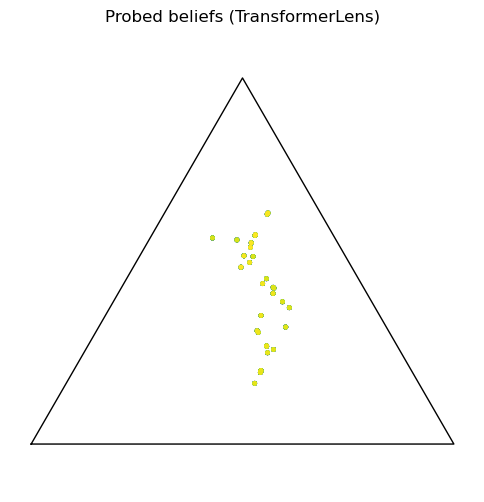

In [ ]:
reps = resid_post.reshape(-1, resid_post.shape[-1]).cpu()
Y = belief_targets[:reps.shape[0]].cpu()  # crop if needed

from sklearn.linear_model import LinearRegression
probe = LinearRegression().fit(reps, Y)
Y_pred = probe.predict(reps)

plot_beliefs_on_simplex(torch.tensor(Y_pred), title="Probed beliefs (TransformerLens)")